Import the needed packages and ml modules 

In [1]:
import numpy as np
import pandas as pd

import xarray as xr
import os
import sys

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchsummary import summary
from sklearn.model_selection import KFold
import torch.nn.functional as F
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import folium
import folium.plugins
import pandas as pd
import xarray as xr
import branca
import branca.colormap as cm

Read offshore and onshore data

In [2]:
d_array = np.memmap('../data/processed/d_CT.dat',
                mode='r+',
                dtype=float,
                shape=(1197, 2224, 912))

t_array = np.memmap('../data/processed/t_CT.dat',
                mode='r+',
                dtype=float,
                shape=(1197, 9, 480))

red_d_array = np.memmap('../data/processed/dflat_CT.dat',
                         mode='r+',
                         dtype=float,
                         shape=(1197, 418877))

Autoencoder model for offshore to onshore time series

In [3]:
# input data
data_in = t_array[:int(len(red_d_array)*0.65),:]
test_data_in = t_array[int(len(red_d_array)*0.65):,:]
data_out = red_d_array[:int(len(red_d_array)*0.65),:]
test_data_out = red_d_array[int(len(red_d_array)*0.65):,:]

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, ninputs=5,t_len = 480, ch_list = [32,64,96], zdim = 50 ):
        super(Autoencoder, self).__init__()
        # more channels mean more fine details, more resolution 
        # less channel and layers less likely to overfit so better maximas and minimas
        # more accuracy but slower and more memory and data needed to train
        self.ch_list = ch_list

        # define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv1d(ninputs, ch_list[0], kernel_size=3, padding=1),   
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,nn.AvgPool1d(kernel_size=2, stride=2),         
            nn.Conv1d(ch_list[0], ch_list[1], kernel_size=3, padding=1),   
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,nn.AvgPool1d(kernel_size=2, stride=2),         
            nn.Conv1d(ch_list[1], ch_list[2], kernel_size=3, padding=1), 
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.1),nn.Flatten(),
            nn.Linear(int(t_len*self.ch_list[-1]/(2**len(ch_list))), zdim),          

        )
        # define decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(zdim,int(t_len*self.ch_list[-1]/(2**len(ch_list)))),
            nn.Unflatten(1, (ch_list[-1], int(t_len/(2**len(ch_list))))) ,
            nn.ConvTranspose1d(ch_list[2], ch_list[1], kernel_size=4, padding=1, stride= 2),  
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,
            nn.ConvTranspose1d(ch_list[1], ch_list[0], kernel_size=4, padding=1, stride= 2), 
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,
            nn.ConvTranspose1d(ch_list[0], ninputs, kernel_size=4, padding=1, stride= 2), 
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,
        )

        # self.latenspace =nn.Sequential(
        #     nn.Linear(int(t_len*self.ch_list[-1]/(2**len(ch_list))), zdim), # 96 x 60 ---> 50 Latent variables #divide by 4 for 2 layers and 8 for three layers
        #     nn.Linear(zdim,int(t_len*self.ch_list[-1]/(2**len(ch_list)))) # 10 Latent variables ---> 96 x 60 )
        # )
    def encode(self, x):
        x = self.encoder(x)
        # x = x.view(x.size(0), -1) # flatten the output
        # print(x.shape)
        return x
    
    def decode(self, x):
        # x = x.view(x.size(0), self.ch_list[-1], -1) # unflatten the output
        x = self.decoder(x)
        # print(x.shape)
        return x
    
    def forward(self, x):
        x = self.encode(x)  
        # x = self.latenspace(x)
        x = self.decode(x)
        return x

In [5]:
np.random.seed(0)
torch.random.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

offshore_model = torch.load(f"./../model/CT/out/model_offshore_ch_[64, 128, 256]_epoch_1000")
onshore_model = torch.load(f"./../model/CT/out/model_onshore_zdim_[64, 64]_epoch_2600.pt")


In [6]:
class mi_Net(nn.Module):
    def __init__(self, layers, **kwargs):
        super(mi_Net, self).__init__()

        # Pretrained offshore and onshore model
        self.offshore_encoder = offshore_model.encoder
        for param in self.offshore_encoder.parameters():
            param.requires_grad = False

        self.onshore_decoder = onshore_model.decoder
        for param in self.onshore_decoder.parameters():
            param.requires_grad = False
      
        # Interface
        if layers == 1:
            self.connect = nn.Sequential(
                                nn.Linear(
                                    in_features=64, out_features=64
                                ),
                                nn.ReLU(),
        ) 
        elif layers == 2:    
            self.connect = nn.Sequential(
                                    nn.Linear(
                                        in_features=64, out_features=64
                                    ),
                                    nn.LeakyReLU(inplace=True),
                                    nn.Linear(
                                        in_features=64, out_features=64
                                    ),
                                    nn.LeakyReLU(inplace=True),
            )

    def forward(self, x):
        x = self.offshore_encoder(x)
        x = self.connect(x)
        x = self.onshore_decoder(x)
        return x

def trainAE(batch_size,nepochs,lr,layers): 
    # Create PyTorch DataLoader objects
    #input-offshore, 
    train_dataset_in = torch.utils.data.TensorDataset(torch.Tensor(data_in[0:int(len(data_in)*0.99)]))   
    train_loader_in = torch.utils.data.DataLoader(train_dataset_in, batch_size=batch_size, shuffle=False)
    val_dataset_in = torch.utils.data.TensorDataset(torch.Tensor(data_in[int(len(data_in)*0.99):]))
    val_loader_in = torch.utils.data.DataLoader(val_dataset_in, batch_size=batch_size, shuffle=False)
    test_dataset_in = torch.utils.data.TensorDataset(torch.Tensor(test_data_in))
    test_loader_in = torch.utils.data.DataLoader(test_dataset_in, batch_size=batch_size, shuffle=False)
    # output-onshore
    train_dataset_out = torch.utils.data.TensorDataset(torch.Tensor(data_out[0:int(len(data_out)*0.99)]))   
    train_loader_out = torch.utils.data.DataLoader(train_dataset_out, batch_size=batch_size, shuffle=False)
    val_dataset_out = torch.utils.data.TensorDataset(torch.Tensor(data_out[int(len(data_out)*0.99):]))
    val_loader_out = torch.utils.data.DataLoader(val_dataset_out, batch_size=batch_size, shuffle=False)
    test_dataset_out = torch.utils.data.TensorDataset(torch.Tensor(test_data_out))
    test_loader_out = torch.utils.data.DataLoader(test_dataset_out, batch_size=batch_size, shuffle=False)

    # Initialize model, optimizer, and loss function
    model = mi_Net(layers=layers)
    model.to('cuda')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    t_epoch_losses = []
    es_epoch_losses = []
    test_epoch_losses = []

    # Train model
    for epoch in range(nepochs):
        train_loss = 0
        es_losses = 0
        test_losses = 0
        for batch_data_in,batch_data_out in zip(train_loader_in,train_loader_out):
            optimizer.zero_grad()
            batch_data_in = batch_data_in[0].to('cuda')
            batch_data_out = batch_data_out[0].to('cuda')
            recon_data = model(batch_data_in)
            loss = criterion(recon_data, batch_data_out)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
                
        for batch_data_in,batch_data_out in zip(val_loader_in,val_loader_out):
            batch_data_in = batch_data_in[0].to('cuda')
            batch_data_out = batch_data_out[0].to('cuda')
            recon_data = model(batch_data_in)
            vloss = criterion(recon_data, batch_data_out)
            es_losses += vloss.item()

        for batch_data_in,batch_data_out in zip(test_loader_in,test_loader_out):
            batch_data_in = batch_data_in[0].to('cuda')
            batch_data_out = batch_data_out[0].to('cuda')
            recon_data = model(batch_data_in)
            tloss = criterion(recon_data, batch_data_out)
            test_losses += tloss.item()

        print(f"NoFold,epoch:{epoch},training loss: {train_loss / len(train_loader_in):.5f},val loss: {es_losses / len(val_loader_in):.5f},test loss:{test_losses / len(test_loader_in):.5f} ", end="\r")
        
        t_epoch_losses.append(train_loss / len(train_loader_in))
        es_epoch_losses.append(es_losses / len(val_loader_in))
        test_epoch_losses.append(test_losses / len(test_loader_in))

        #save model at every 200th epoch
        if epoch % 200 == 0:
            torch.save(model, f"./../model/out/model_onshore_layers_{layers}_epoch_{epoch}.pt")
        
        #plot training/val loss
        plt.plot(t_epoch_losses, color='blue')
        plt.plot(es_epoch_losses, color='red')
        plt.plot(test_epoch_losses, color='green')
        plt.title(f"Training loss for Nofold")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.yscale('log')
        plt.savefig(f"./../model/plot/off2onshore_Pretrained_layers{layers}.png")   
        # plt.clf()
   
    #append z info + train,val,test loss to file as new line
    with open(f"./../model/out/model_off2onshore_loss.txt", "a") as text_file:
        text_file.write(f"layers: {layers}, train loss: {t_epoch_losses[-1]}, val loss: {es_epoch_losses[-1]}, test loss: {test_losses / len(test_loader_in):.5f}\n")
    text_file.close()   


In [7]:
# y = data.shape[1] 
# x = data.shape[2]
#64 128 256
#64 32

# ninputs = 5
# t_len = 480
# xy= data_out.shape[1]
batch_size = 20
num_epochs = 4000
learning_rate = 0.0005
layers = 2


test loss: 0.00905


Text(0, 0.5, 'Reconstructed')

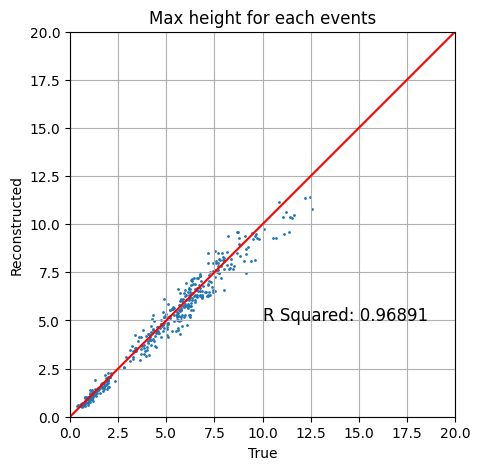

In [8]:
#read model from file for testing
model = torch.load(f"./../model/CT/out/model_onshore_layers_2_epoch_400.pt")
model.eval()
# summary(model, (ninputs,t_len,xy))

# Test model for final evaluation
predic = np.zeros(test_data_out.shape)
criterion = nn.MSELoss()  
test_dataset_in = torch.utils.data.TensorDataset(torch.Tensor(test_data_in))
test_loader_in = torch.utils.data.DataLoader(test_dataset_in, batch_size=batch_size, shuffle=False)
test_dataset_out = torch.utils.data.TensorDataset(torch.Tensor(test_data_out))
test_loader_out = torch.utils.data.DataLoader(test_dataset_out, batch_size=batch_size, shuffle=False)

# Test model
with torch.no_grad():
    test_loss = 0
    for batch_idx,(batch_data_in,batch_data_out) in enumerate(zip(test_loader_in,test_loader_out)):
        batch_data_in = batch_data_in[0].to('cuda')
        batch_data_out = batch_data_out[0].to('cuda')
        recon_data = model(batch_data_in)
        loss = criterion(recon_data, batch_data_out)
        test_loss += loss.item()
        predic[batch_idx*batch_size:(batch_idx+1)*batch_size] = recon_data.cpu().numpy()
    print(f"test loss: {test_loss / len(test_loader_in):.5f}")

# Plot results max height for all events
test_max = np.max(test_data_out,axis=(1))
recon_max = np.max(predic,axis=(1))

plt.figure(figsize=(5, 5))
plt.scatter(test_max, recon_max, s=1)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.title(f"Max height for each events")
plt.text(10,5,f"R Squared: {r2_score(test_max, recon_max):.5f} ", fontsize=12)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')


In [9]:
def calc_scores(true,pred,locindices,threshold=0.2):
    #only test where there is significant flooding
    true[true<threshold] = 0
    predic[predic<threshold] = 0
    mse_val = mean_squared_error(true,pred)
    r2_val = r2_score(true,pred)
    pt_er = true[locindices] - pred[locindices]

    # sel = true>=threshold
    # true = true[sel]
    # pred = pred[sel]
    # #to avoid division by zero    
    # pred[pred==0]=1e-10
    # #calculate Aidan's no K and k small 
    # ratio = true/pred
    # logval = np.log(ratio)
    # logval_sq = logval**2

    # logk = logval.mean()

    # logksmall = ((logval_sq.mean()) - (logk**2))**0.5
    # KCap = np.exp(logk)
    # Ksmall = np.exp(logksmall)

    return mse_val,r2_val,true[locindices],pred[locindices],pt_er #,KCap,Ksmall


In [10]:
control_points =  [[37.5022,15.0960],
          [37.48876,15.08936],
          [37.47193,15.07816],
          [37.46273,15.08527],
          [37.46252,15.08587],
          [37.45312,15.07874],
          [37.42821,15.08506],
          [37.40958,15.08075],
          [37.38595,15.08539],
          [37.35084,15.08575],
          [37.33049,15.07029],
          [37.40675,15.05037]
          ]

        #points to evaluate
# (2130, 653, 416589)
# (1980, 595, 406966)
# (1794, 496, 382850)
# (1691, 559, 366654)
# (1689, 564, 366384)
# (1585, 501, 348891)
# (1308, 557, 300485)
# (1101, 519, 261213)
# (839, 560, 196458)
# (450, 563, 127165)
# (224, 427, 61790)
# (1070, 252, 252416)

In [11]:
all_ids = np.loadtxt('../data/events/shuffled_events_CT.txt', ,skiprows=0)
test_ids = all_ids[int(len(all_ids)*0.65):]
eve_info = pd.read_csv('../data/info/about_alleve1212_PS.txt', sep='\t')
locindices = [416589,406966,382850,366654,366384,348891,300485,261213,196458,127165,61790,252416] #control points

#check performance per event
eve_perf = []
true_list = []
pred_list = []
er_list = []

#mse_val,r2_val,pt_er,KCap,Ksmall,truecount,predcount
for eve_no,eve in enumerate(test_ids):
    scores = calc_scores(test_data_out[eve_no,:], predic[eve_no,:],locindices,threshold=0.1)
    eve_perf.append([scores[0],scores[1],#scores[3],scores[4], #mse,r2,KCap,Ksmall
                     np.count_nonzero(test_data_out[eve_no,:]), #true count
                     np.count_nonzero(predic[eve_no,:])]) #pred count
    true_list.append(scores[2])
    pred_list.append(scores[3])
    er_list.append(scores[4])

#count of events less than 
eve_perf = np.array(eve_perf)
true_list = np.array(true_list)
pred_list = np.array(pred_list)
er_list = np.array(er_list)

#combine columns of true,pred,er into 12 column array
true_pred_er = np.column_stack((true_list,pred_list,er_list))


In [12]:
#save to file
np.savetxt(f"./../model/CT/out/er_onshore_pretrained_epoch_{num_epochs}.csv",eve_perf,fmt='%.5f',delimiter=',')


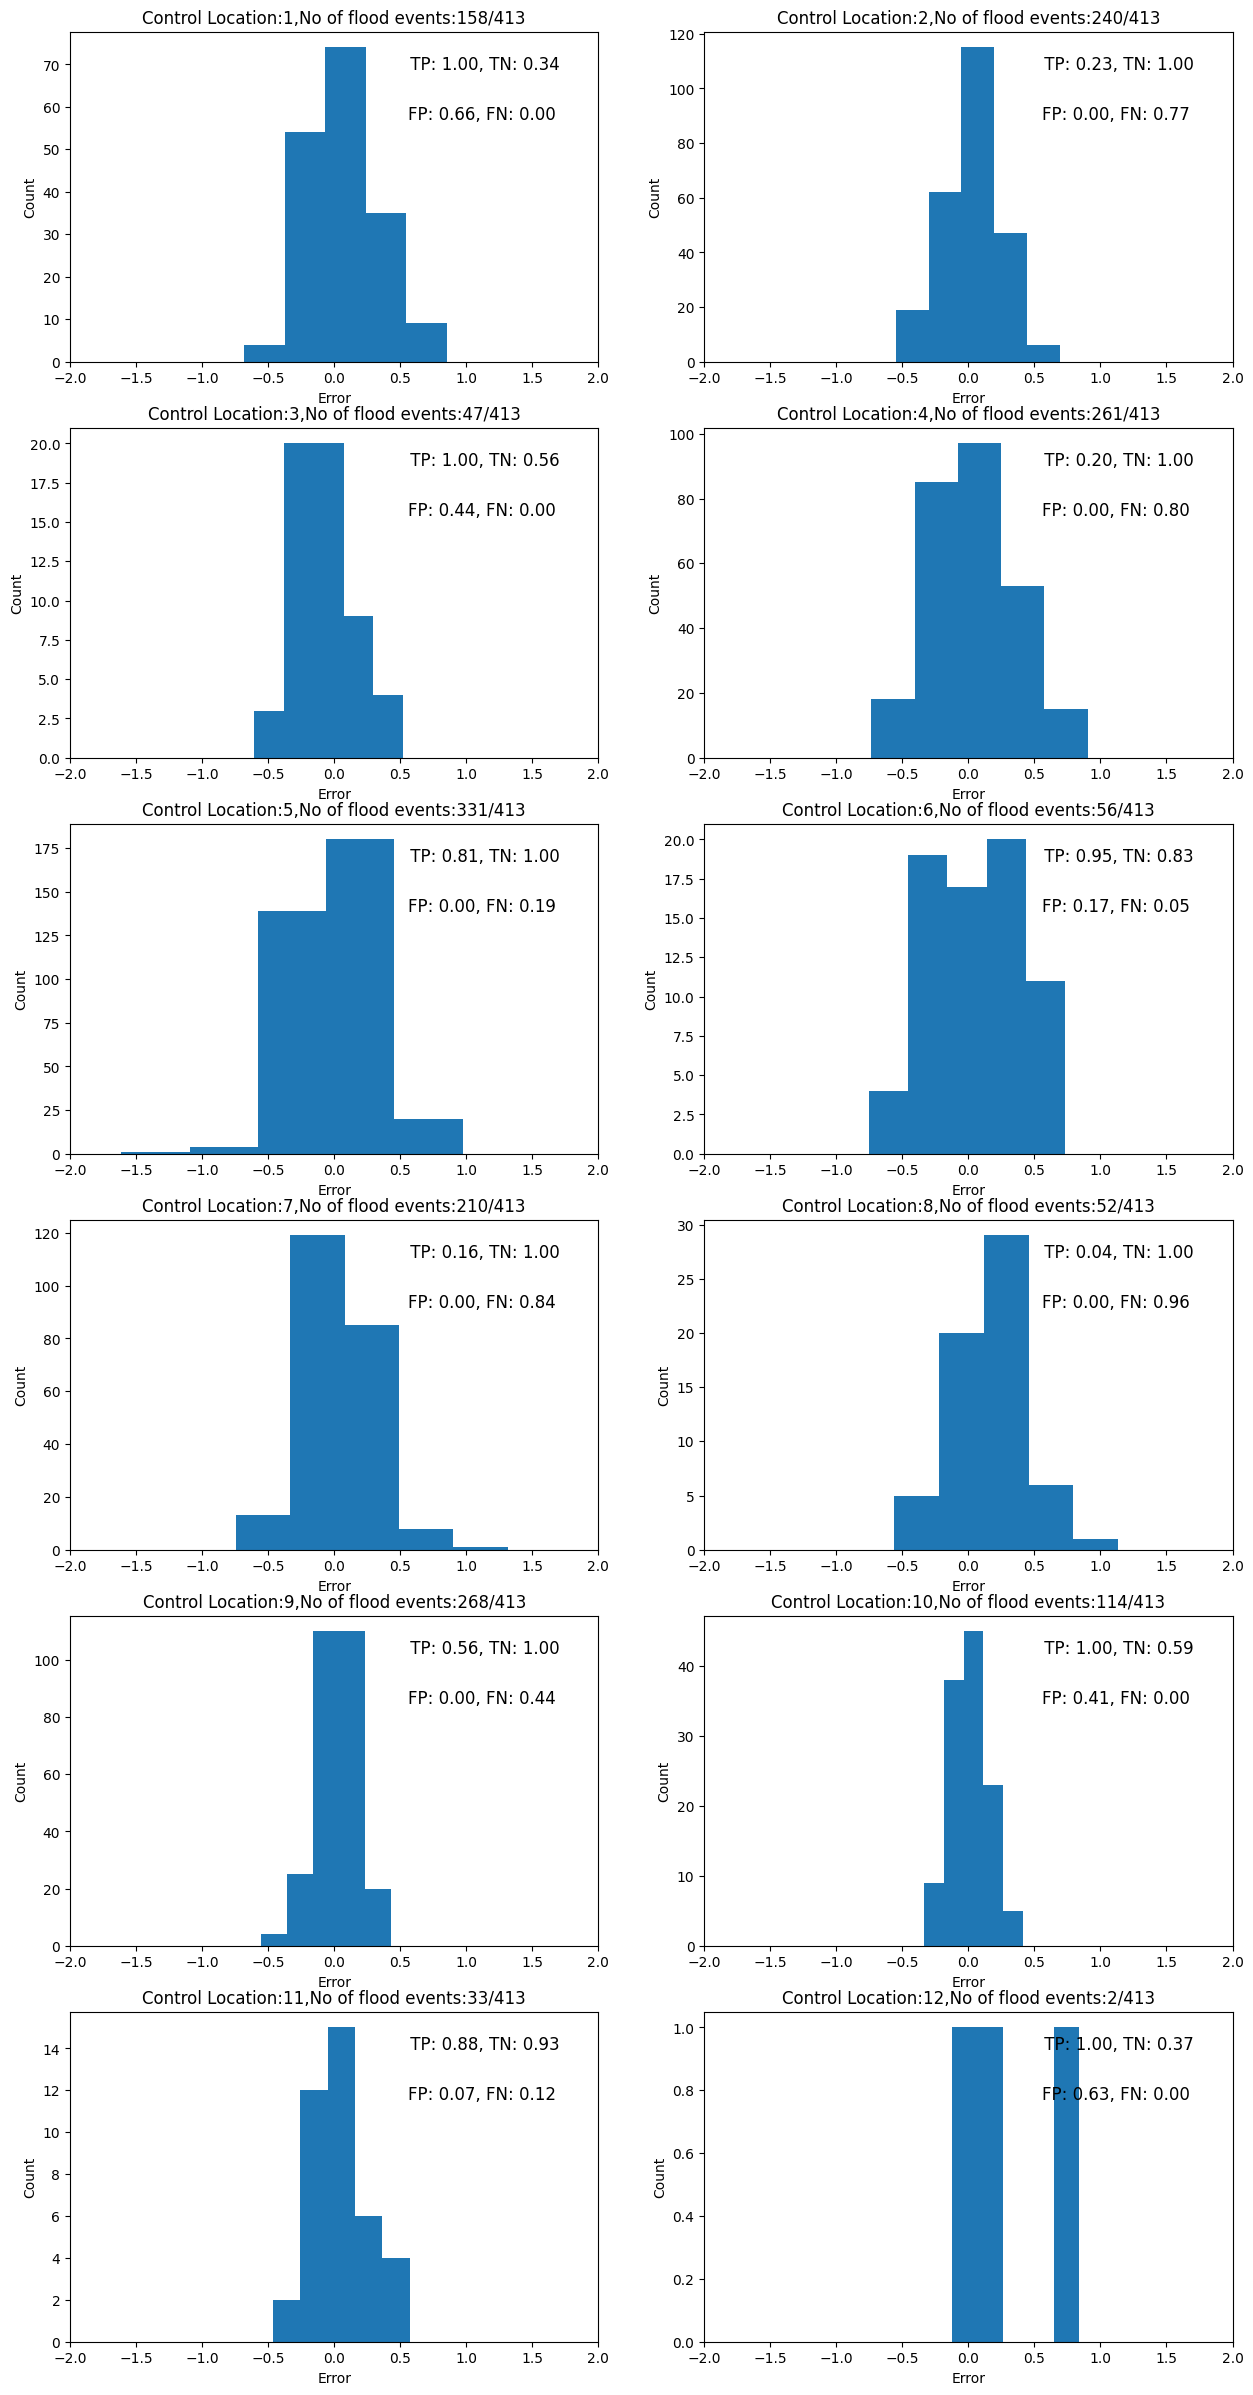

In [13]:
#plot the errors for the 4 locations as subplot from all events as histogram
plt.figure(figsize=(15, 30))
for i in range(12):
    plt.subplot(6,2,i+1)
    plt.hist(er_list[er_list[:,i]!=0,i],bins=5)
    #set x axis to be the same for all subplots
    plt.xlim(-2,2)
    #calculate hit and mis for each location based on depth of true and prediction
    #events crossing the threshold of 0.2 are considered flooded
    neve = np.count_nonzero(true_pred_er[:,i]>0.1)
    threshold = 0.1
    #true positive: true>0.2 and pred>0.2
    TP = np.count_nonzero((true_pred_er[:,i]>threshold) & (true_pred_er[:,i+4]>threshold))/(neve)
    TN = np.count_nonzero((true_pred_er[:,i]<threshold) & (true_pred_er[:,i+4]<threshold))/(len(true_pred_er[:,i])-neve)
    FP = np.count_nonzero((true_pred_er[:,i]<threshold) & (true_pred_er[:,i+4]>threshold))/(len(true_pred_er[:,i])-neve)
    FN = np.count_nonzero((true_pred_er[:,i]>threshold) & (true_pred_er[:,i+4]<threshold))/(neve)
    plt.title(f"Control Location:{i+1},No of flood events:{neve}/413")
    plt.text(0.78, 0.9, f" TP: {TP:.2f}, TN: {TN:.2f}", horizontalalignment='center',verticalalignment='center', transform=plt.gca().transAxes,fontsize=12)
    plt.text(0.78, 0.75, f"FP: {FP:.2f}, FN: {FN:.2f}", horizontalalignment='center',verticalalignment='center', transform=plt.gca().transAxes,fontsize=12)
    plt.xlabel('Error')
    plt.ylabel('Count')
    # plt.grid()
# plt.suptitle(f"Error distribution for 4 control locations for {len(eve_perf)} test events")

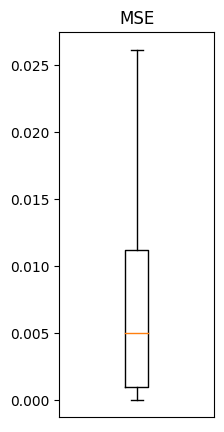

([], [])

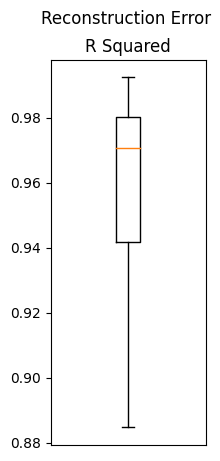

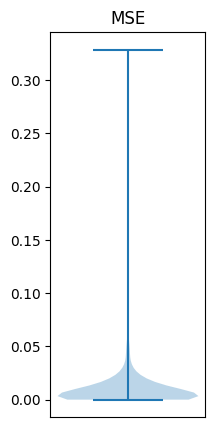

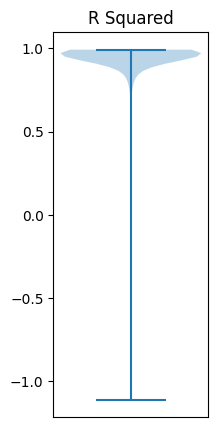

In [14]:
#plot the mse and r2 for all the events as box plot
plt.figure(figsize=(2, 5))
plt.boxplot(eve_perf[:,0],showfliers=False)
plt.title('MSE')
plt.xticks([])

plt.show()
plt.figure(figsize=(2, 5))
plt.boxplot(eve_perf[:,1],showfliers=False)
plt.title('R Squared')
plt.xticks([])

plt.suptitle(f"Reconstruction Error") # {len(eve_perf)} test events


# #make violin plot of the errors
# plt.figure(figsize=(15, 10))
# for i in range(4):
#     plt.subplot(2,2,i+1)
#     plt.violinplot(er_list[er_list[:,i]!=0,i],showmeans=True)
#     plt.xlim(-1,1)
#     plt.title(f"Control Location:{i+1}")
#     plt.xlabel('Error')
#     plt.ylabel('Count')
#     # plt.grid()


#make violin plot of the errors MSE and R2
plt.figure(figsize=(2, 5))
plt.violinplot(eve_perf[:,0],showmeans=False)
plt.title('MSE')
plt.xticks([])
plt.figure(figsize=(2, 5))
plt.violinplot(eve_perf[:,1],showmeans=False)
plt.title('R Squared')
plt.xticks([])
# plt.suptitle(f"Reconstruction Error") # {len(eve_perf)} test events



E01517N3917E01678N3772-PS-Mur_PNo_Hom-M792_E01654N3866_S000
E02113N3823E02873N3483-PS-Mur_PYes_Var-M792_E02227N3683_S000
E01548N3896E01854N3659-PS-Mur_PYes_Hom-M707_E01601N3726_S000
E02020N3739E02658N3366-PS-Str_PYes_Var-M902_E02188N3566_S003
E02113N3823E02873N3483-PS-Str_PYes_Hom-M792_E02259N3628_S000
E01548N3896E01854N3659-PS-Str_PYes_Var-M861_E01734N3775_S001
E01964N3926E02184N3685-PS-Str_PNo_Var-M754_E02088N3719_S000



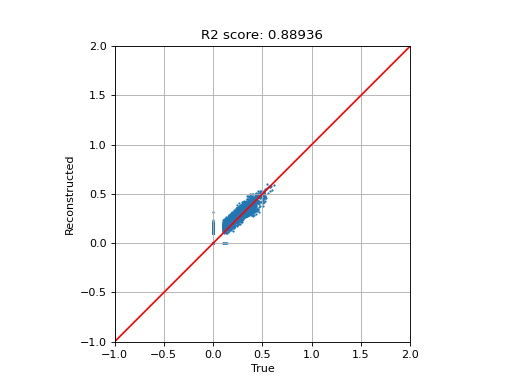
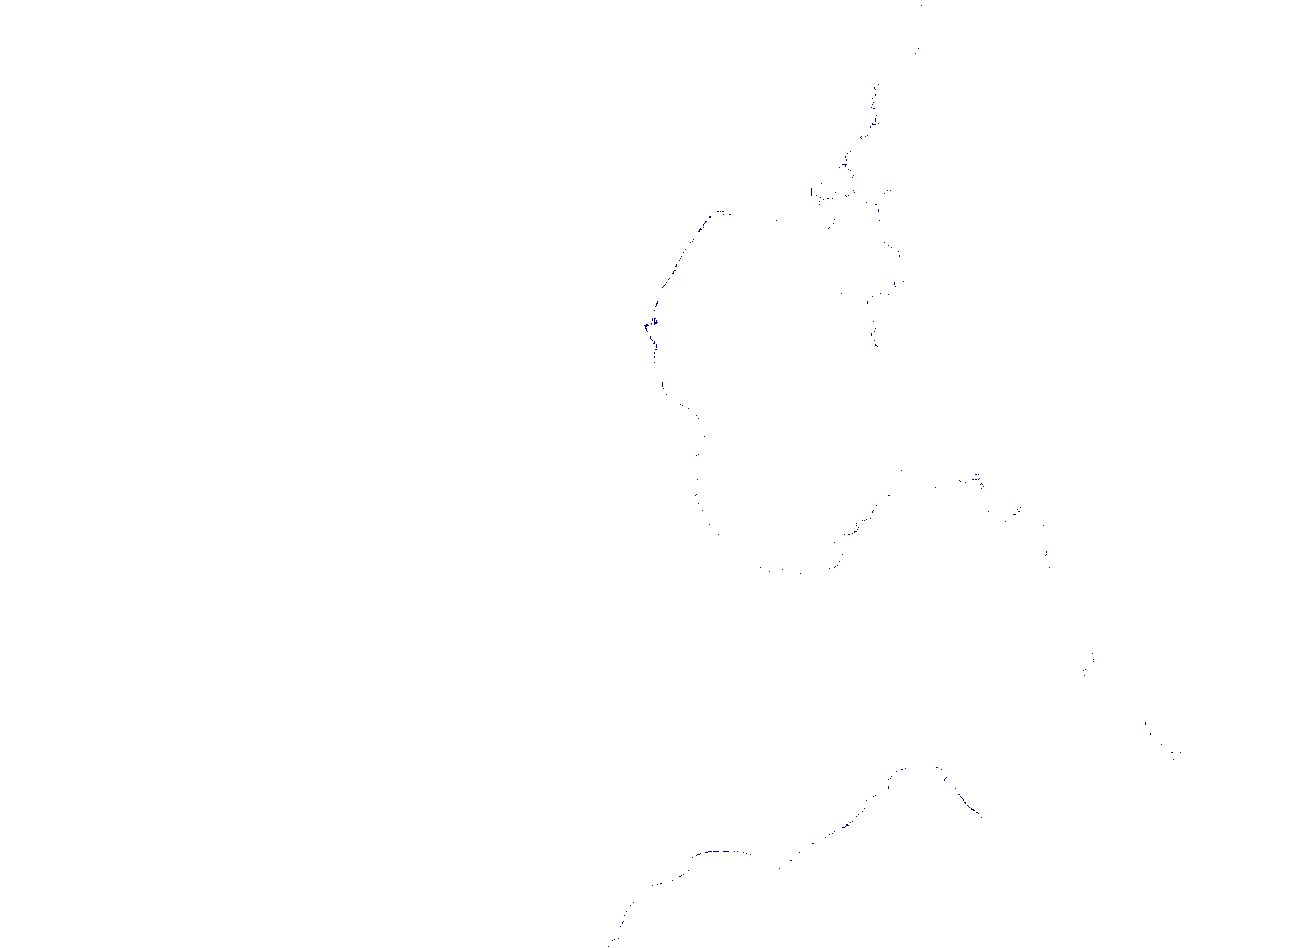
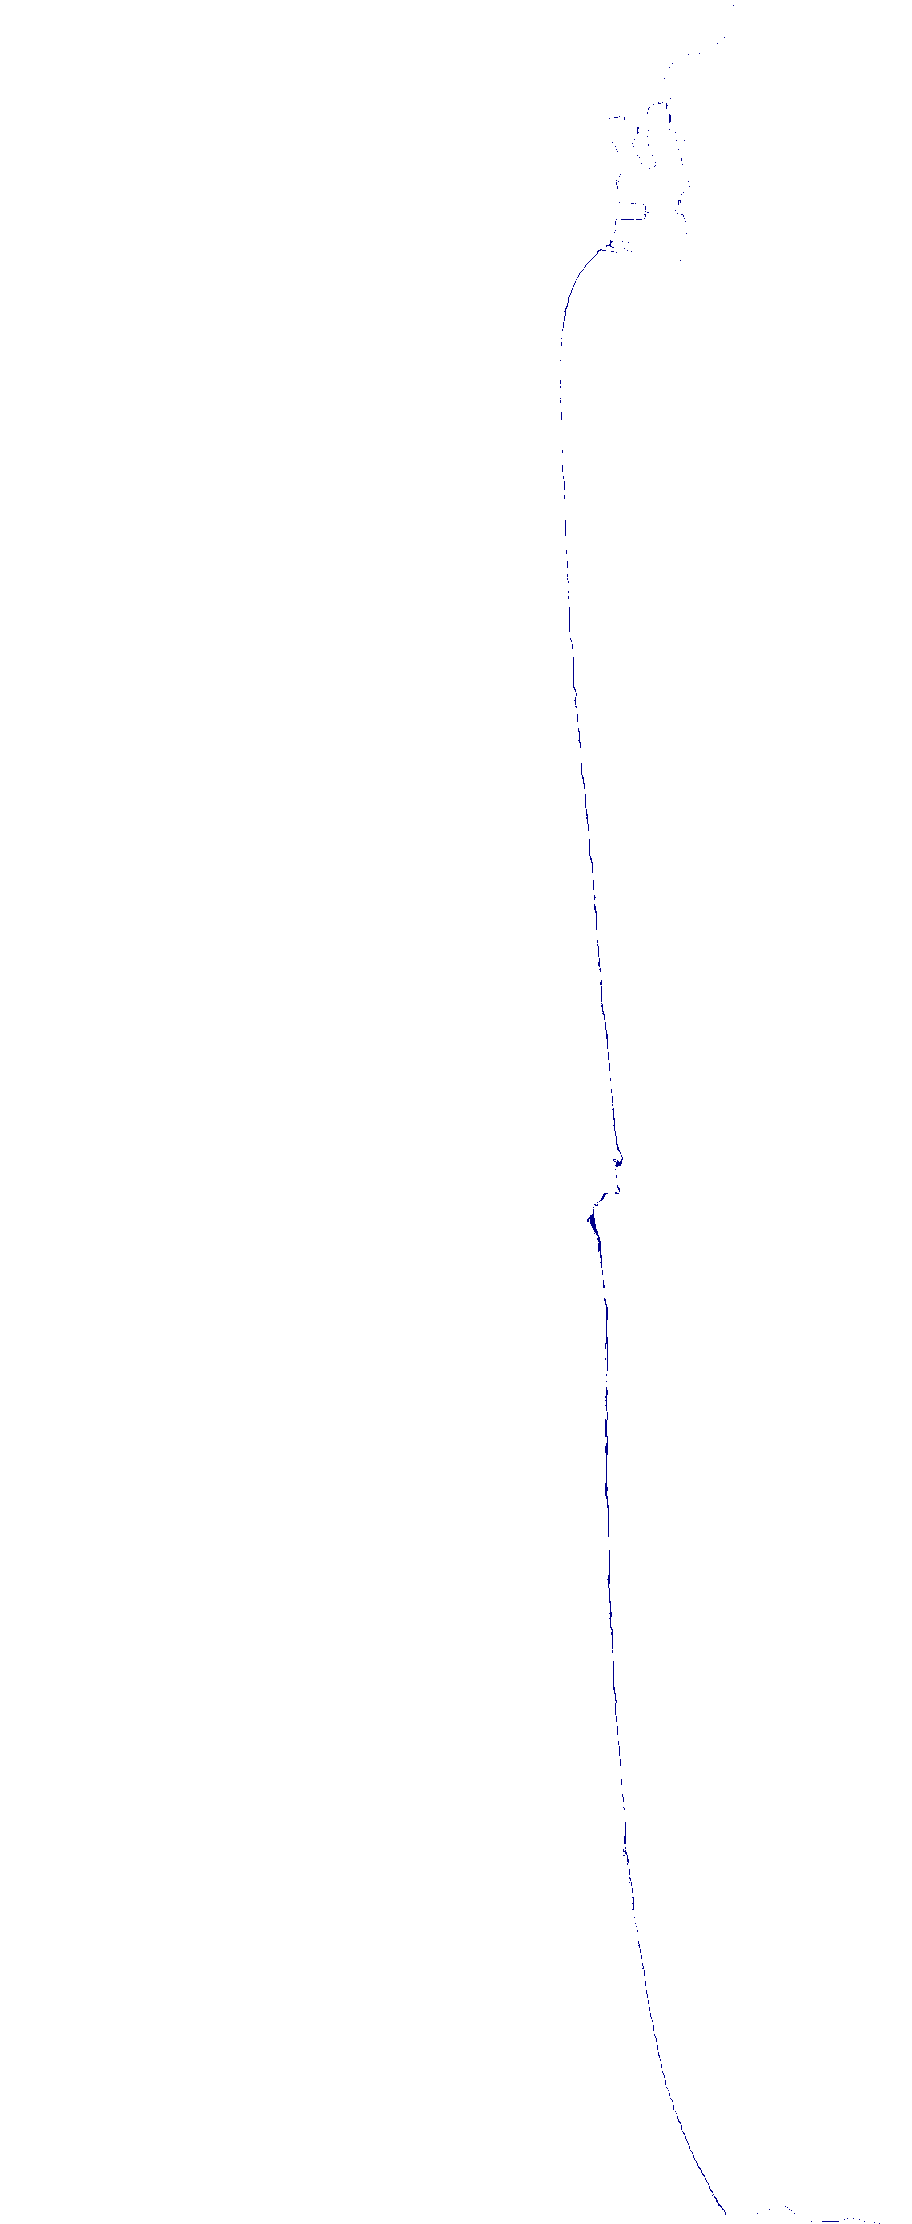
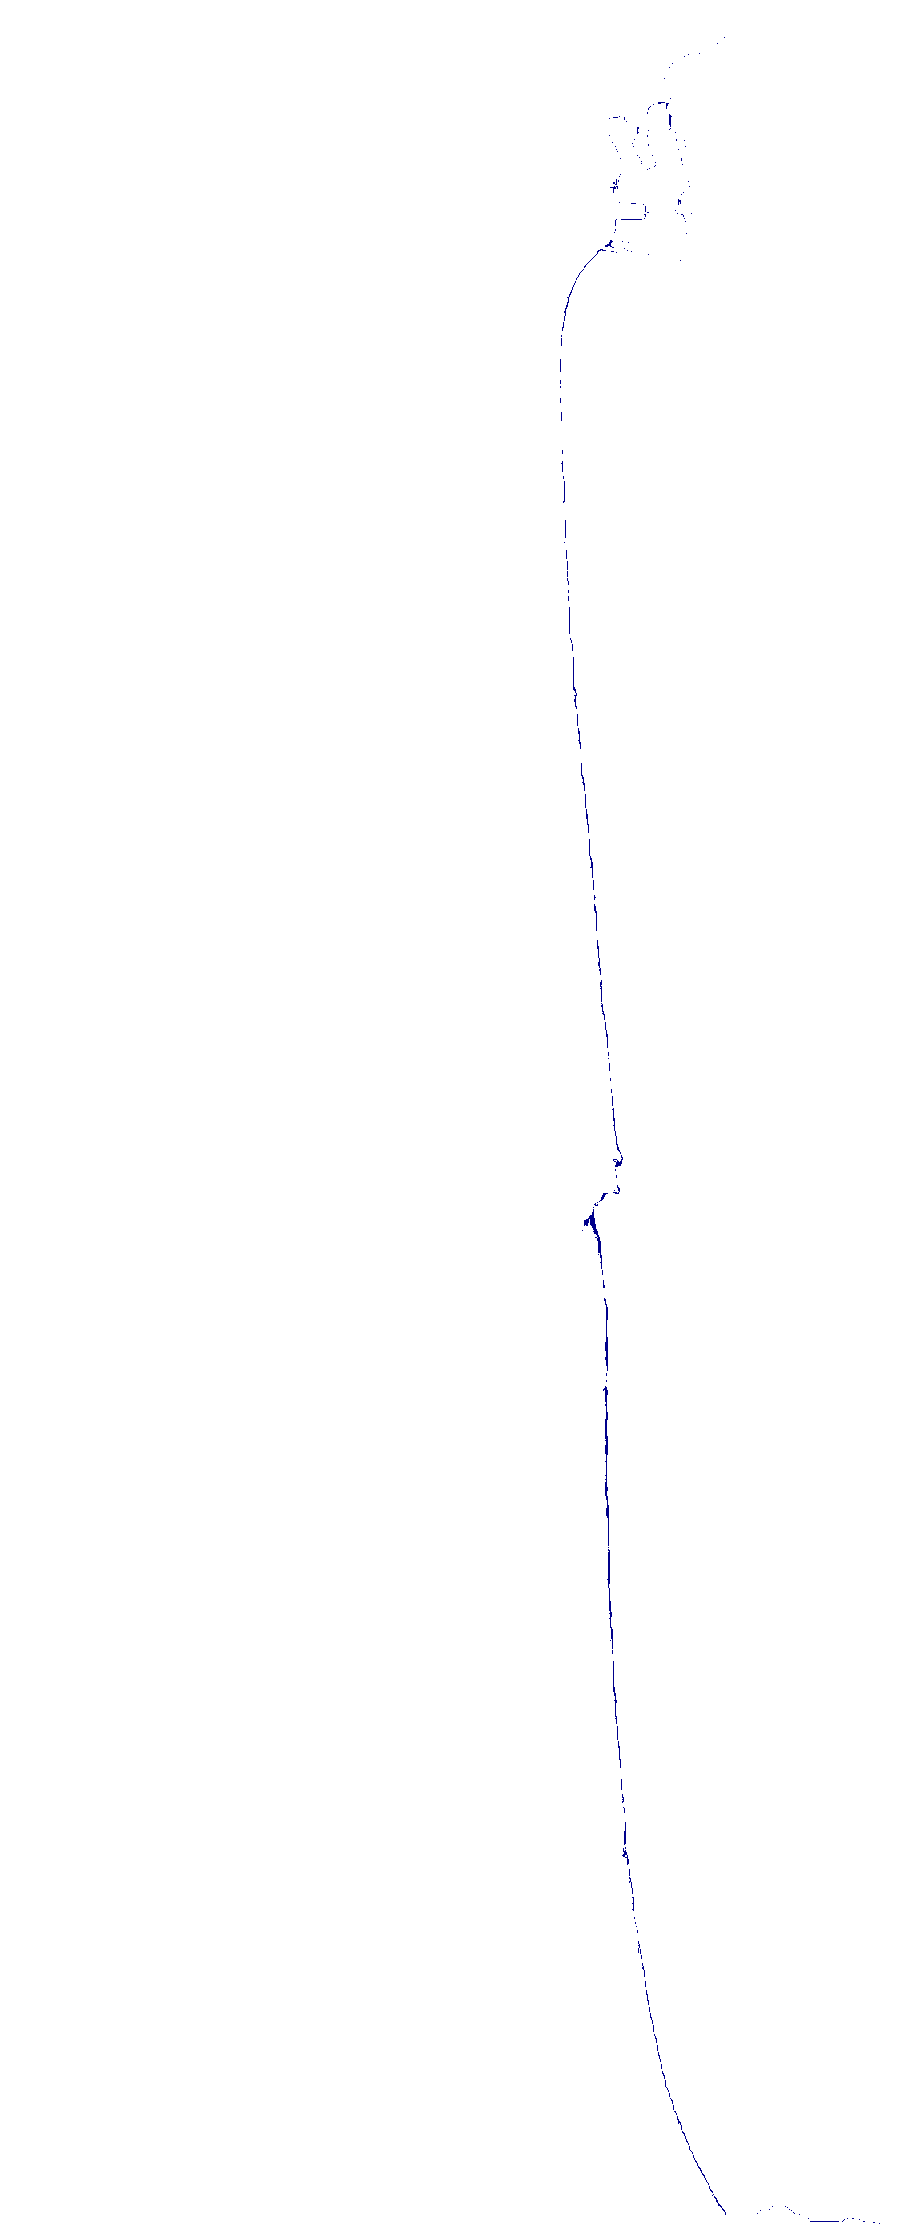
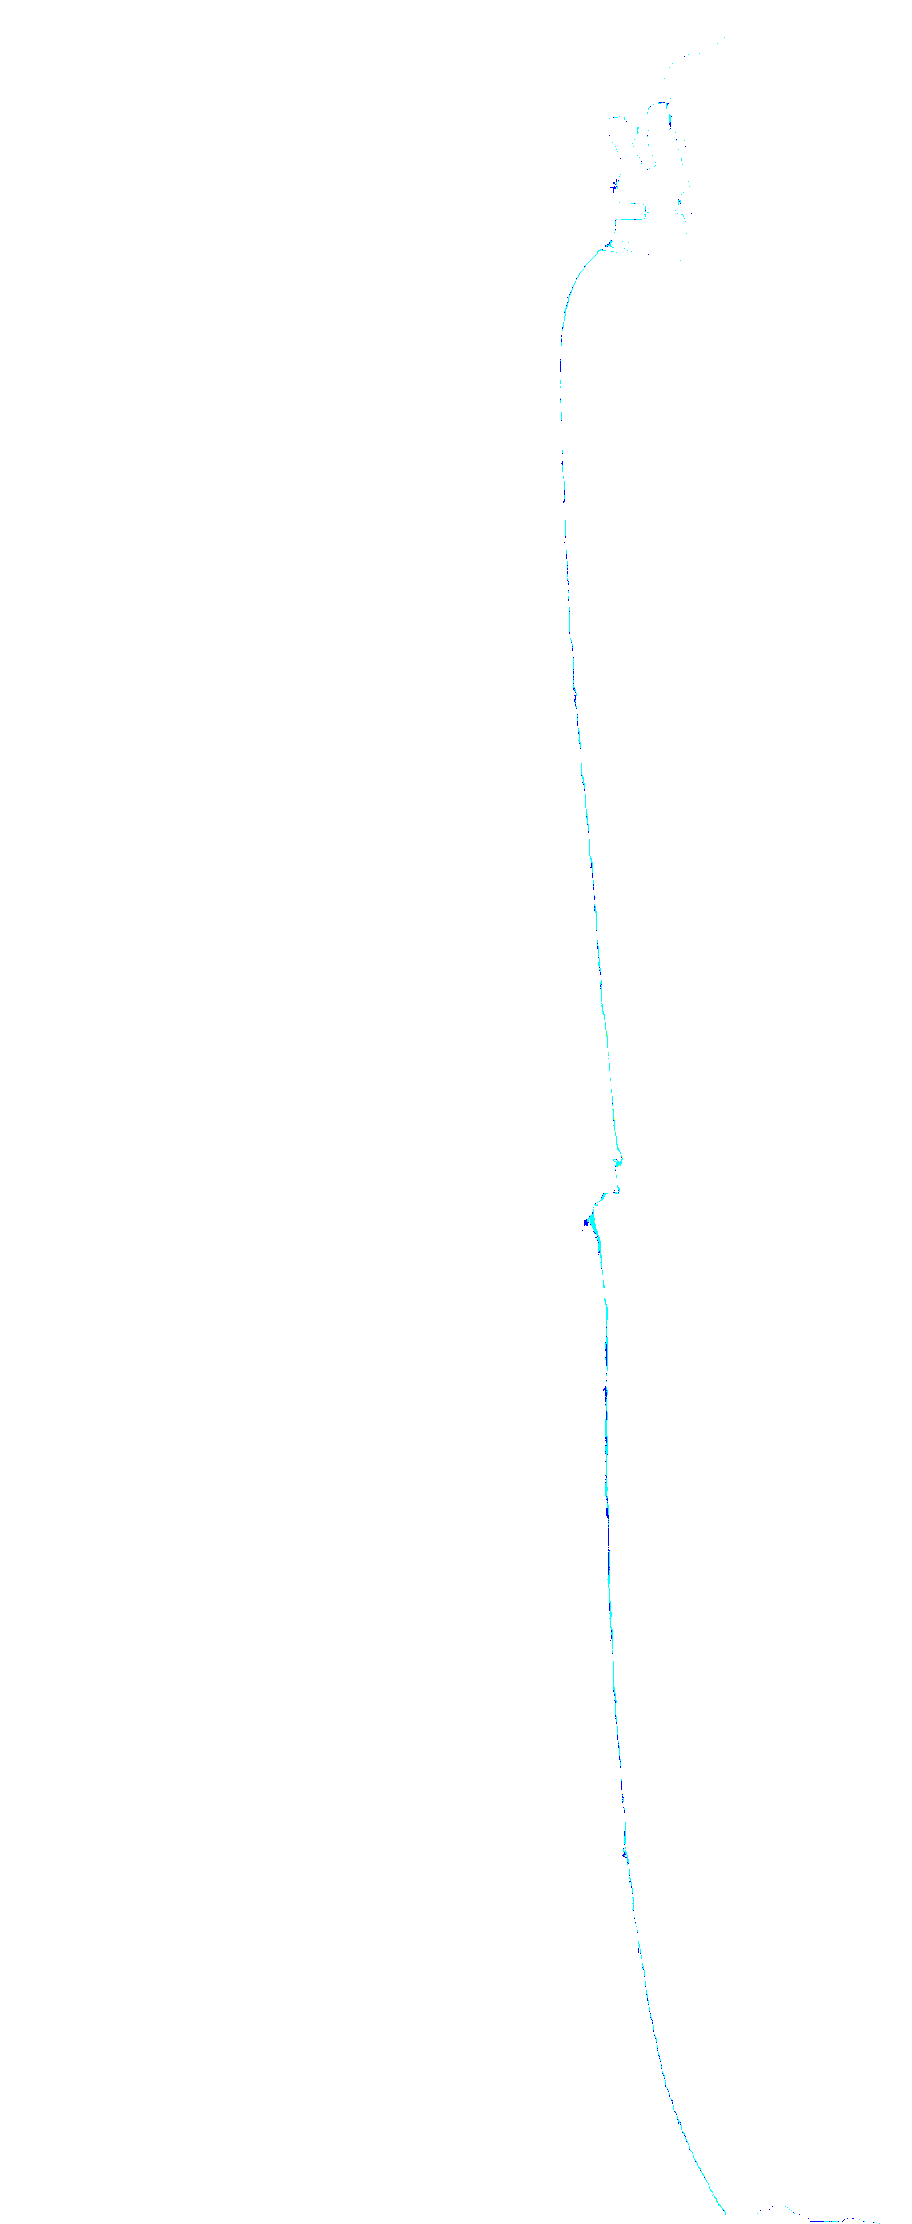

In [19]:
import base64
eventlist = 176,93,139,267,357,242,169
for eve_no in eventlist:
        eve = test_ids[eve_no]
        # Plot results max depth and error for one event with basemap around sicily

        #grid map
        error2fill = np.zeros(d_array.shape[1:])
        depth2fill = np.zeros(d_array.shape[1:])

        zero_mask = np.load('../data/processed/CT_zero_mask.npy')
        error2fill[~zero_mask] = test_data_out[eve_no, :] - predic[eve_no, :]
        depth2fill[~zero_mask] = predic[eve_no,:]

        true = test_data_out[eve_no,:]
        pred = predic[eve_no,:]
        true[true<threshold] = 0
        pred[pred<threshold] = 0

        plt.scatter(true, pred, s=1)
        plt.title(f"R2 score: {eve_perf[eve_no,1]:.5f}")
        plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlim(pred.min().round(0)-1, true.max().round(0)+1)
        plt.ylim(pred.min().round(0)-1, true.max().round(0)+1)
        plt.grid()
        plt.xlabel('True')
        plt.ylabel('Reconstructed')
        #save to file
        image_path = './../resources/gis/true_pred.png'
        plt.savefig(image_path,dpi=80)
        plt.close()
        # plt.show()

        sim_dir = '../data/simu/PS_manning003/'
        # Load the points file
        data_pts = np.loadtxt('../resources/raw/pois_eastern_sicily_2km.txt', dtype=str)
        id_pts = data_pts[:, 0]
        lon_pts = data_pts[:, 1].astype(float)
        lat_pts = data_pts[:, 2].astype(float)
        z_pts = data_pts[:, 3].astype(float)

        ds_ts = xr.open_dataset(os.path.join(sim_dir,eve,'grid0_ts.nc')) #gridts file
        ds_grids_CT = xr.open_dataset(os.path.join(sim_dir,eve,'CT_flowdepth.nc')) #gridts file
        ds_grids_SR = xr.open_dataset(os.path.join(sim_dir,eve,'SR_flowdepth.nc')) #gridts file

        # Create a Folium map centered on the data's extent
        # m = folium.Map(location=[np.mean(lat_pts),np.mean(lon_pts)], zoom_start=10)
        m = folium.Map(location=[37.39564 , 15.08389], zoom_start=13.5)
        # Basemaps
        folium.TileLayer(tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                attr = 'Esri',
                name = 'Esri Satellite',
                overlay = False,
                control = True,
                show = False).add_to(m)

        # Create a feature group for the offshore points 
        fg_pts = folium.FeatureGroup(name='Offshore Points Txt').add_to(m)
        fg_ptsNC = folium.FeatureGroup(name='Offshore Points NetCDF').add_to(m)
        fg_gridnc_SR = folium.FeatureGroup(name='SR Grid NetCDF').add_to(m)
        fg_gridnc_CT = folium.FeatureGroup(name='CT Grid NetCDF').add_to(m)
        fg_gridnc_ML_d = folium.FeatureGroup(name='ML Grid Depth NetCDF').add_to(m)
        fg_gridnc_ML_e = folium.FeatureGroup(name='ML Grid Error NetCDF').add_to(m)
        fg_conpts_CT = folium.FeatureGroup(name='CT Control Points').add_to(m)

        with open(image_path, 'rb') as lf:
                # open in binary mode, read bytes, encode, decode obtained bytes as utf-8 string
                b64_content = base64.b64encode(lf.read()).decode('utf-8')

        folium.plugins.FloatImage('data:image/png;base64,{}'.format(b64_content), bottom=2, left=2).add_to(m)


        #add eq lat lon point
        print(eve)

        # E01548N3896E01854N3659-PS-Str_PYes_Hom-M861_E01673N3781_S005
        lon = float(str(eve).split('_')[-2][1:5])/10
        lat = float(str(eve).split('_')[-2][7:11])/100

        folium.CircleMarker(location=[lat,lon],radius = 15,color='red',fill_color = 'red').add_to(m)

        # Add a marker for each point with a tooltip showing its id
        for id, lat, lon,z in zip(id_pts, lat_pts, lon_pts, z_pts):
                info = f"ID:{id}, Depth: {z} "  # Create tooltip string
                folium.Marker(location=[lat, lon],
                                tooltip=info,
                                icon=folium.Icon(color='blue', icon='')).add_to(fg_pts)

        # Add a marker for each point with a tooltip showing its id
        for i,pt in enumerate(control_points):
                folium.Marker(location=[pt[0], pt[1]],
                popup=folium.Popup("Control Point " + '{:01d}'.format(i+1),
                                        show=True)).add_to(fg_conpts_CT)


        df_ts = pd.DataFrame({'lat':ds_ts.latitude.values.astype(float),
                        'lon':ds_ts.longitude.values.astype(float),
                        'z':ds_ts.deformed_bathy.values.astype(float)})

        for i,row in df_ts.iterrows():
                info = f"ID:{i}, Depth: {row['z']} "  # Create tooltip string
                folium.Marker(location=[row['lat'], row['lon']],
                                tooltip=info,
                                icon=folium.Icon(color='red', icon='')).add_to(fg_ptsNC)

        # Add grid netcdfs
        #COLORMAP
        cmap = matplotlib.colors.ListedColormap(['darkblue', 'blue', 'cyan', 'yellow', 'orange', 'red','#FFFFFF00'])
        norm_fun = matplotlib.colors.BoundaryNorm([0.1, 1, 2, 5 , 7.5, 10,99999], cmap.N)

        colorbar = cm.LinearColormap(colors=['darkblue', 'blue', 'cyan', 'yellow', 'orange', 'red'],
                                index=[0.1, 1, 2, 5 , 7.5, 10], vmin=0.1, vmax=10,
                                caption='Max flow depth[m]')

        colorbar.add_to(m) 

        #SIRACUSA 
        data2plot = ds_grids_SR#.isel(time=0)
        data = np.flipud(data2plot.z.values.astype(float))
        data[data < threshold ] = np.nan
        lon,lat = np.meshgrid(data2plot.lon.values.astype(float),
                        data2plot.lat.values.astype(float))

        ext = [[lat.min(),lon.min()],
                [lat.max(),lon.max()]]
        folium.raster_layers.ImageOverlay(cmap(norm_fun(data)),ext,opacity=0.5).add_to(fg_gridnc_SR)


        #CATANIA 
        data2plot = ds_grids_CT#.isel(time=0)
        data = np.flipud(data2plot.z.values.astype(float))
        data[data < threshold] = np.nan
        lon,lat = np.meshgrid(data2plot.lon.values.astype(float),
                        data2plot.lat.values.astype(float))

        ext = [[lat.min(),lon.min()],
                [lat.max(),lon.max()]]

        folium.raster_layers.ImageOverlay(cmap(norm_fun(data)),ext,opacity=0.75).add_to(fg_gridnc_CT)

        #plot recon depth and error
        error2fill = np.flipud(error2fill)
        depth2fill = np.flipud(depth2fill)
        error2fill[depth2fill < threshold] = np.nan
        depth2fill[depth2fill < threshold] = np.nan
        folium.raster_layers.ImageOverlay(cmap(norm_fun(depth2fill)),ext,opacity=0.75).add_to(fg_gridnc_ML_d)

        ecmap = matplotlib.colors.ListedColormap(['darkblue', 'blue', 'cyan', 'yellow', 'orange', 'red','#FFFFFF00'])
        error_fun = matplotlib.colors.BoundaryNorm([-2.5,-1,-0.1,0.1,1,2.5,99], ecmap.N)

        ecolorbar = cm.LinearColormap(colors=['darkblue', 'blue', 'cyan', 'yellow', 'orange', 'red'],
                                index=[-2.5,-1,0,1,2.5], vmin=-2.5, vmax=2.5,
                                caption='Error in Max flow depth[m]')
        ecolorbar.add_to(m)
      
        folium.raster_layers.ImageOverlay(cmap(error_fun(error2fill)),ext,opacity=0.75).add_to(fg_gridnc_ML_e)

        # Add a layer control to turn on/off the feature groups
        folium.LayerControl().add_to(m)
        folium.plugins.MousePosition().add_to(m)

        #save as html
        m.save(f'./../model/CT/plot/CTevent_example_{eve_no}.html')

m

In [30]:
# print(model)
summary(model,(9,480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 480]           1,792
         LeakyReLU-2              [-1, 64, 480]               0
         AvgPool1d-3              [-1, 64, 240]               0
            Conv1d-4             [-1, 128, 240]          24,704
         LeakyReLU-5             [-1, 128, 240]               0
         AvgPool1d-6             [-1, 128, 120]               0
            Conv1d-7             [-1, 256, 120]          98,560
         LeakyReLU-8             [-1, 256, 120]               0
         AvgPool1d-9              [-1, 256, 60]               0
          Dropout-10              [-1, 256, 60]               0
          Flatten-11                [-1, 15360]               0
           Linear-12                   [-1, 64]         983,104
           Linear-13                   [-1, 64]           4,160
        LeakyReLU-14                   

In [31]:
for param in model.offshore_encoder.parameters():
    print(param.shape, param.requires_grad)

torch.Size([64, 9, 3]) False
torch.Size([64]) False
torch.Size([128, 64, 3]) False
torch.Size([128]) False
torch.Size([256, 128, 3]) False
torch.Size([256]) False
torch.Size([64, 15360]) True
torch.Size([64]) True


In [32]:
for param in model.onshore_decoder.parameters():
    print(param.shape, param.requires_grad)

torch.Size([64, 64]) True
torch.Size([64]) True
torch.Size([418877, 64]) False
torch.Size([418877]) False


In [33]:
for param in model.connect.parameters():
    print(param.shape, param.requires_grad)

torch.Size([64, 64]) True
torch.Size([64]) True
torch.Size([64, 64]) True
torch.Size([64]) True


In [34]:
for param in model.parameters():
    print(param.shape, param.requires_grad)

torch.Size([64, 9, 3]) False
torch.Size([64]) False
torch.Size([128, 64, 3]) False
torch.Size([128]) False
torch.Size([256, 128, 3]) False
torch.Size([256]) False
torch.Size([64, 15360]) True
torch.Size([64]) True
torch.Size([64, 64]) True
torch.Size([64]) True
torch.Size([64, 64]) True
torch.Size([64]) True
torch.Size([64, 64]) True
torch.Size([64]) True
torch.Size([418877, 64]) False
torch.Size([418877]) False
